# Fifty One and Pytorch Installation

In [ ]:
!pip install fiftyone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached fiftyone-0.18.0-py3-none-any.whl (2.3 MB)
  Using cached sse_starlette-0.10.3-py3-none-any.whl (8.0 kB)
  Using cached voxel51_eta-0.8.1-py2.py3-none-any.whl (564 kB)
  Using cached ndjson-0.3.1-py2.py3-none-any.whl (5.3 kB)
  Using cached universal_analytics_python3-1.1.1-py3-none-any.whl (10 kB)
  Using cached strawberry_graphql-0.138.1-py3-none-any.whl (192 kB)
  Using cached motor-3.1.1-py3-none-any.whl (56 kB)
  Using cached fiftyone_db-0.4.0-py3-none-manylinux1_x86_64.whl (37.8 MB)
  Using cached xmltodict-0.13.0-py2.py3-none-any.whl (10.0 kB)
  Using cached sseclient_py-1.7.2-py2.py3-none-any.whl (8.4 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached eventlet-0.33.2-py2.py3-none-any.whl (226 kB)
  Using cached Hypercorn-0.14.3-py3-none-any.whl (57 kB)
  Using cached dacite-1.7.0-py3-none-any.whl (12 kB)
  Using cached aiofiles-22.1.0-py3-none-a

In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz
import torch
import torchvision
from PIL import Image
from torchvision.transforms import functional
from fiftyone import ViewField

Migrating database to v0.18.0


INFO:fiftyone.migrations.runner:Migrating database to v0.18.0


# Load Dataset COCO 2017

In [ ]:
coco_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    dataset_name="evaluate-detections-tutorial",
)
coco_dataset.persistent = True

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [7.8s elapsed, 0s remaining, 274.9Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [7.8s elapsed, 0s remaining, 274.9Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading images to '/root/fiftyone/coco-2017/tmp-download/val2017.zip'


 100% |██████|    6.1Gb/6.1Gb [23.8s elapsed, 0s remaining, 271.2Mb/s]      


INFO:eta.core.utils: 100% |██████|    6.1Gb/6.1Gb [23.8s elapsed, 0s remaining, 271.2Mb/s]      


Extracting images to '/root/fiftyone/coco-2017/validation/data'


INFO:fiftyone.utils.coco:Extracting images to '/root/fiftyone/coco-2017/validation/data'


Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████| 5000/5000 [28.5s elapsed, 0s remaining, 171.1 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [28.5s elapsed, 0s remaining, 171.1 samples/s]      


Dataset 'evaluate-detections-tutorial' created


INFO:fiftyone.zoo.datasets:Dataset 'evaluate-detections-tutorial' created


In [ ]:
# Print some information about the dataset
print(coco_dataset)

Name:        evaluate-detections-tutorial
Media type:  image
Num samples: 5000
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)


In [ ]:
# Print a ground truth detection
dataset_sample = coco_dataset.first()
print(dataset_sample.ground_truth.detections[0])

<Detection: {
    'id': '63a6482ca88aa495f4088d6b',
    'attributes': {},
    'tags': [],
    'label': 'potted plant',
    'bounding_box': [
        0.37028125,
        0.3345305164319249,
        0.038593749999999996,
        0.16314553990610328,
    ],
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'furniture',
    'iscrowd': 0,
}>


In [ ]:
session = fo.launch_app(coco_dataset)

# Load Model

In [ ]:
# Run the model on GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load a pre-trained Faster R-CNN model
retina_model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
retina_model.to(device)
retina_model.eval()

print("Models are ready")

Models are ready


# Prediction

In [ ]:
retina_pred = coco_dataset.take(5000)

In [ ]:
# Get class list
classes = coco_dataset.default_classes

In [ ]:
# Add predictions to samples
with fo.ProgressBar() as pb:
    for retina_sample in pb(retina_pred):
        # Load image
        image = Image.open(retina_sample.filepath)
        image = functional.to_tensor(image).to(device)
        c, h, w = image.shape
        
        # Perform inference
        preds = retina_model([image])[0]
        labels = preds["labels"].cpu().detach().numpy()
        scores = preds["scores"].cpu().detach().numpy()
        boxes = preds["boxes"].cpu().detach().numpy()
        
        # Convert detections to FiftyOne format
        detections = []
        for label, score, box in zip(labels, scores, boxes):
            # Convert to [top-left-x, top-left-y, width, height]
            # in relative coordinates in [0, 1] x [0, 1]
            x1, y1, x2, y2 = box
            rel_box = [x1 / w, y1 / h, (x2 - x1) / w, (y2 - y1) / h]

            detections.append(
                fo.Detection(
                    label=classes[label],
                    bounding_box=rel_box,
                    confidence=score
                )
            )
        
        # Save predictions to dataset
        retina_sample["retina"] = fo.Detections(detections=detections)
        retina_sample.save()

 100% |███████████████| 5000/5000 [15.7m elapsed, 0s remaining, 5.6 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [15.7m elapsed, 0s remaining, 5.6 samples/s]      


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


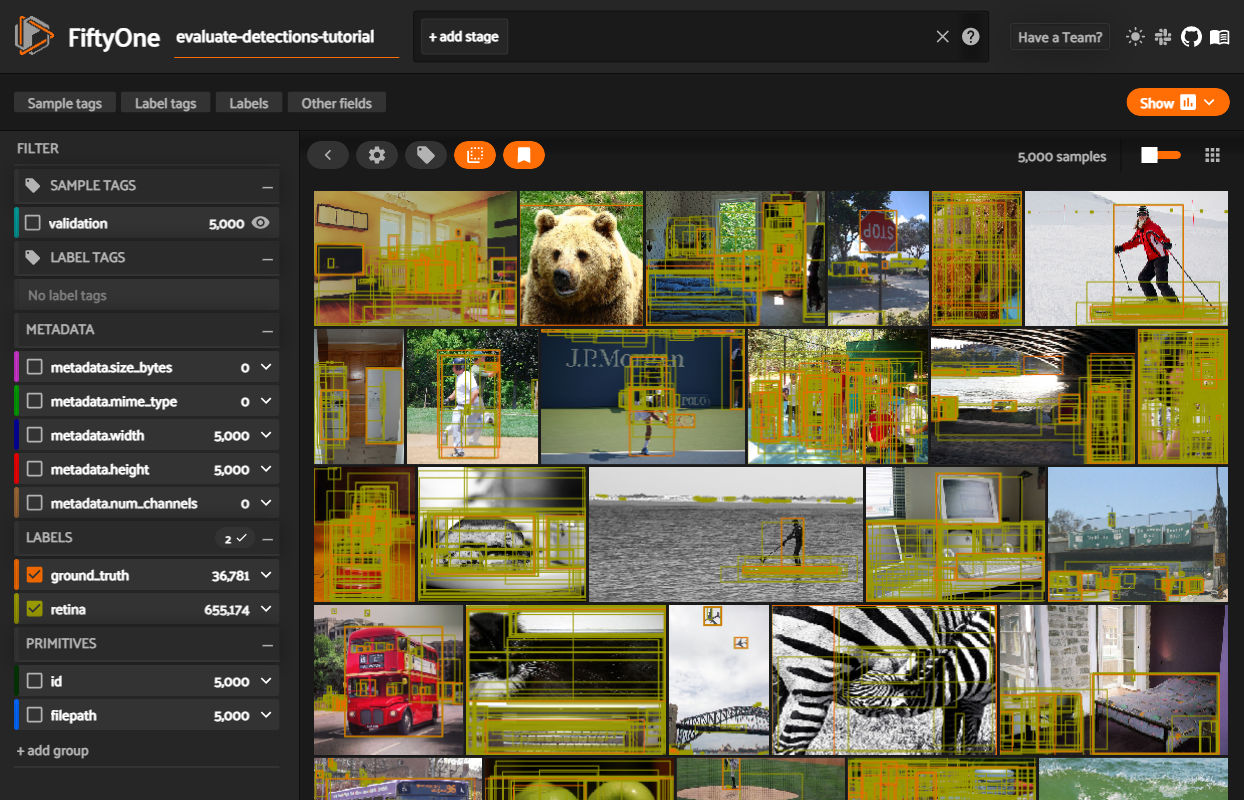

<IPython.core.display.Javascript object>

In [ ]:
session.show()

# Confidence Threshold

In [ ]:
# Only contains detections with confidence >= 0.5
conf_retina = retina_pred.filter_labels("retina", ViewField("confidence") > 0.5, only_matches=False)

In [ ]:
session.view = conf_retina

# retinanet_resnet50_fpn Evaluation

In [ ]:
# Evaluate the predictions in the `retina` field of our `high_conf_view`
# with respect to the objects in the `ground_truth` field
retina_results = conf_retina.evaluate_detections(
    "retina",
    gt_field="ground_truth",
    eval_key="eval",
    compute_mAP=True,
)

 100% |███████████████| 5000/5000 [3.0m elapsed, 0s remaining, 31.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [3.0m elapsed, 0s remaining, 31.0 samples/s]      


Performing IoU sweep...


INFO:fiftyone.utils.eval.coco:Performing IoU sweep...


 100% |███████████████| 5000/5000 [1.4m elapsed, 0s remaining, 74.9 samples/s]      


INFO:eta.core.utils: 100% |███████████████| 5000/5000 [1.4m elapsed, 0s remaining, 74.9 samples/s]      


In [ ]:
ious_retina_sum = 0
for i in range(len(retina_results.ious)):
  if retina_results.ious[i] != None:
    ious_retina_sum += retina_results.ious[i]
ious_retina_avg = ious_retina_sum/len(retina_results.ious)
print(ious_retina_avg)

0.3682839265347993


In [ ]:
# Get the 10 most common classes in the dataset
retina_counts = coco_dataset.count_values("ground_truth.detections.label")
retina_classes_sorted = sorted(retina_counts, key=retina_counts.get, reverse=True)

# Print a classification report for the top-10 classes
retina_results.print_report(classes = retina_classes_sorted)

                precision    recall  f1-score   support

        person       0.90      0.64      0.75     11390
           car       0.83      0.52      0.64      1969
         chair       0.73      0.24      0.36      1798
          book       0.67      0.06      0.12      1164
        bottle       0.80      0.36      0.50      1044
           cup       0.79      0.40      0.53       905
  dining table       0.72      0.26      0.38       697
 traffic light       0.70      0.40      0.51       638
          bowl       0.78      0.37      0.50       628
       handbag       0.62      0.12      0.20       540
          bird       0.89      0.46      0.61       464
          boat       0.72      0.34      0.46       431
         truck       0.66      0.40      0.50       415
      umbrella       0.81      0.45      0.58       421
         bench       0.67      0.25      0.37       413
           cow       0.82      0.61      0.70       391
        banana       0.73      0.23      0.35  

In [ ]:
print(retina_results.mAP())

0.2971235613419349


In [ ]:
plot = retina_results.plot_pr_curves(classes=[
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
])
plot.show()

In [ ]:
retina_sample = conf_retina.first()
print(retina_sample.retina.detections[0])

<Detection: {
    'id': '63a648a3a88aa495f40930a0',
    'attributes': {},
    'tags': [],
    'label': 'elephant',
    'bounding_box': [
        0.0029432285577058793,
        0.25152894655863445,
        0.7327116966247559,
        0.7410515467325847,
    ],
    'mask': None,
    'confidence': 0.9977568984031677,
    'index': None,
    'eval_iou': 0.973431694381355,
    'eval_id': '63a64843a88aa495f40914b7',
    'eval': 'tp',
}>


In [ ]:
retina_eval_patches = coco_dataset.to_evaluation_patches("eval")
print(retina_eval_patches)

Dataset:     evaluate-detections-tutorial
Media type:  image
Num patches: 674004
Patch fields:
    id:           fiftyone.core.fields.ObjectIdField
    sample_id:    fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    retina:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    crowd:        fiftyone.core.fields.BooleanField
    type:         fiftyone.core.fields.StringField
    iou:          fiftyone.core.fields.FloatField
View stages:
    1. ToEvaluationPatches(eval_key='eval', config=None)


In [ ]:
session.view = retina_eval_patches